In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 5

In [2]:
N_FEATURES = 3
N_TIME_STEPS = 200
N_CLASSES = 6
N_HIDDEN_UNITS = 64

N_EPOCHS = 100
BATCH_SIZE = 1024
LEARNING_RATE = 0.0025
L2_LOSS = 0.0015

RANDOM_SEED = 42

In [3]:
def read_data(file_path):
    column_names = ['user-id','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
    data = pd.read_csv(file_path,header = None, names = column_names)
    return data

def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma

def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([-2, 2])
    ax.set_xlim([min(x), max(x)])
    
def plot_activity(activity, data):
    data = data[data['activity'] == activity][:200]
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (16, 12), sharex = True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    fig.suptitle(activity)
    plt.show()

In [4]:
df = read_data('WISDM_ar_v1.1_raw.txt')
df['x-axis'] = feature_normalize(df['x-axis'])
df['y-axis'] = feature_normalize(df['y-axis'])
df['z-axis'] = feature_normalize(df['z-axis'])
df = df.dropna()
LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

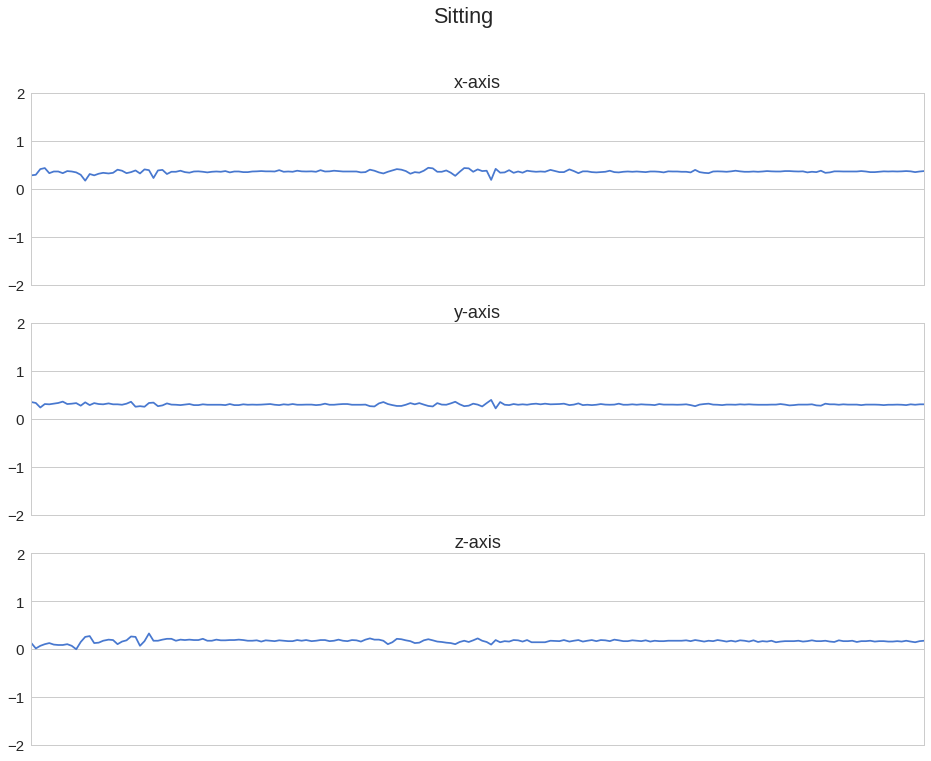

In [5]:
plot_activity("Sitting", df)

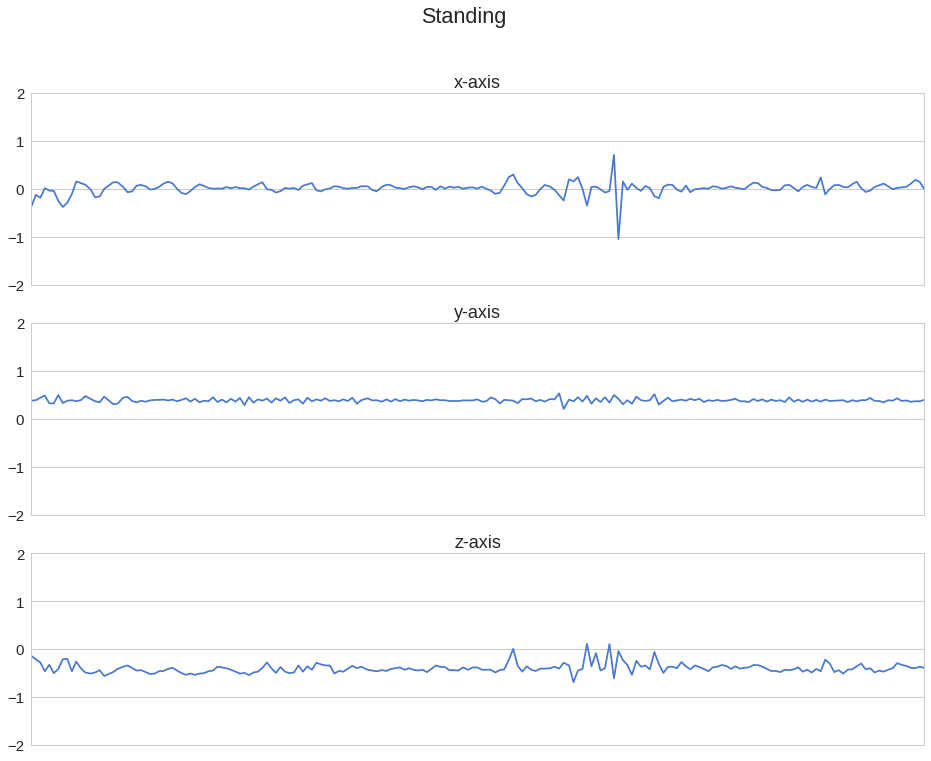

In [6]:
plot_activity("Standing", df)

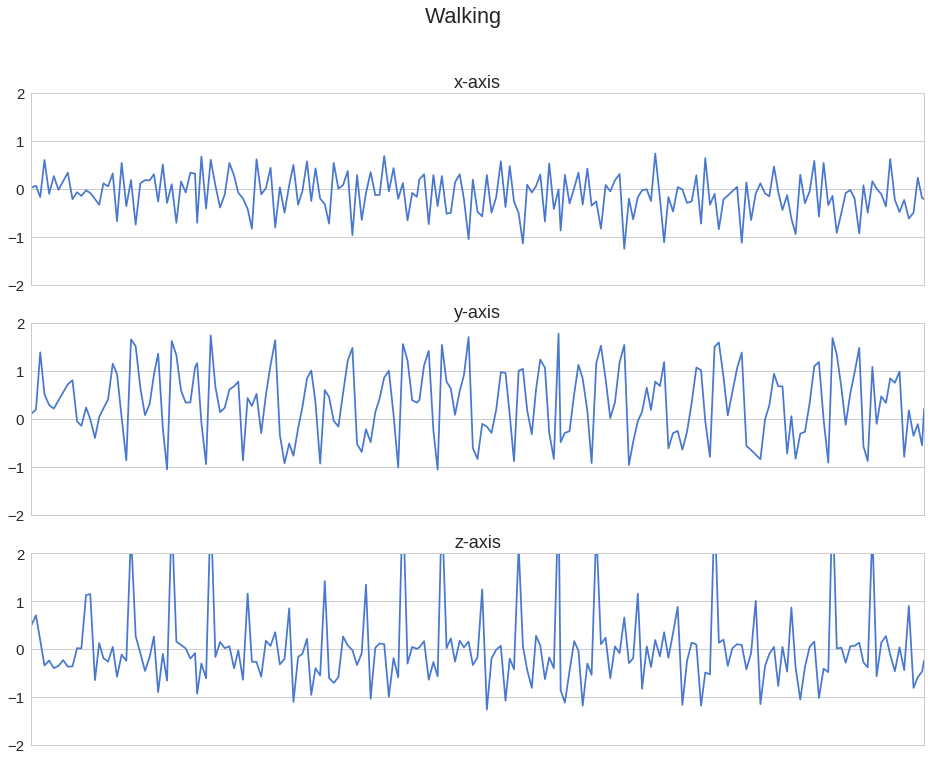

In [7]:
plot_activity("Walking", df)

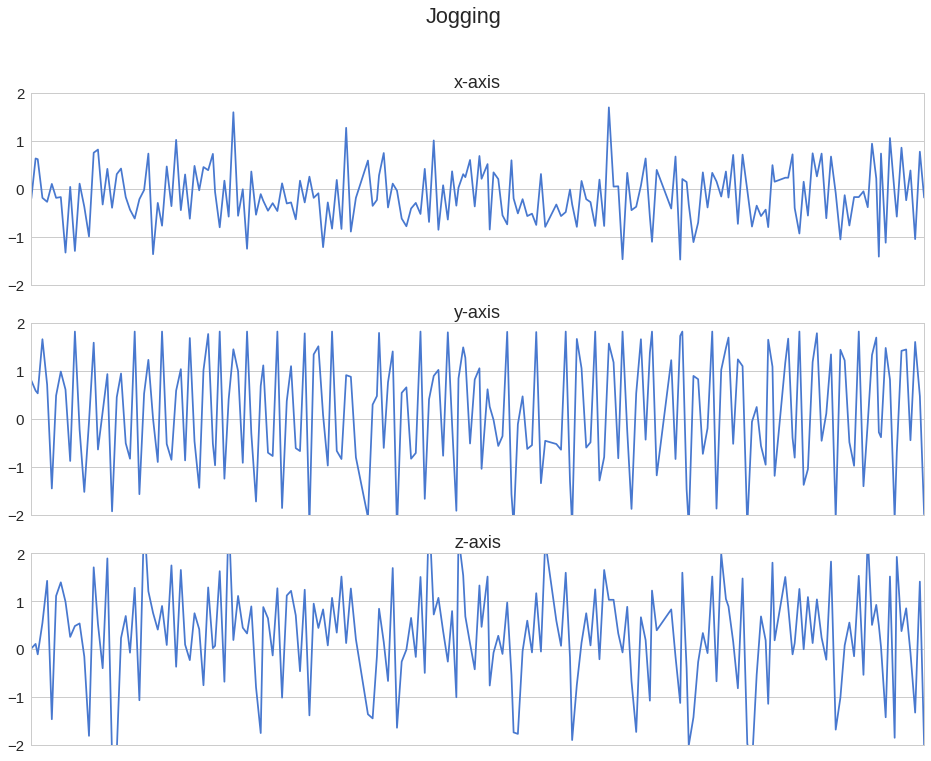

In [8]:
plot_activity("Jogging", df)

In [9]:
step = 20
segments = []
labs = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    lbl = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labs.append(lbl)

/home/vini/.pyenv/versions/3.6.1/envs/teaching/lib/python3.6/site-packages/scipy/stats/stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [10]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labs), dtype = np.float32)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [12]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [ ]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(cost)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

# Training

In [ ]:
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])


sess=tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(N_EPOCHS):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})


    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, cost], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, cost], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    if i % 10 != 0:
        continue


    print("traing iter: {},".format(i)+\
          " test accuracy : {},".format(acc_test)+\
          " loss : {}".format(loss_test))
    
predictions, _, _ = sess.run([pred_softmax, accuracy, cost], feed_dict={X: X_test, Y: y_test})

pickle.dump(predictions, open("predictions.p", "wb"))
pickle.dump(history, open("history.p", "wb"))
tf.train.write_graph(sess.graph_def, '.', './checkpoint/har.pbtxt')  
saver.save(sess, save_path = "./checkpoint/har.ckpt");

traing iter: 0, test accuracy : 0.7645021677017212, loss : 1.4452024698257446
traing iter: 10, test accuracy : 0.9249610900878906, loss : 0.6521380543708801
traing iter: 20, test accuracy : 0.9680353999137878, loss : 0.4095946252346039
traing iter: 30, test accuracy : 0.9675800800323486, loss : 0.33731991052627563
traing iter: 40, test accuracy : 0.9633910655975342, loss : 0.3010868728160858
traing iter: 70, test accuracy : 0.9755028486251831, loss : 0.22019284963607788
traing iter: 80, test accuracy : 0.9755029678344727, loss : 0.2083435356616974
traing iter: 90, test accuracy : 0.9823328256607056, loss : 0.1852129101753235


In [ ]:
history = pickle.load(open("history.p", "rb"))
predictions = pickle.load(open("predictions.p", "rb"))

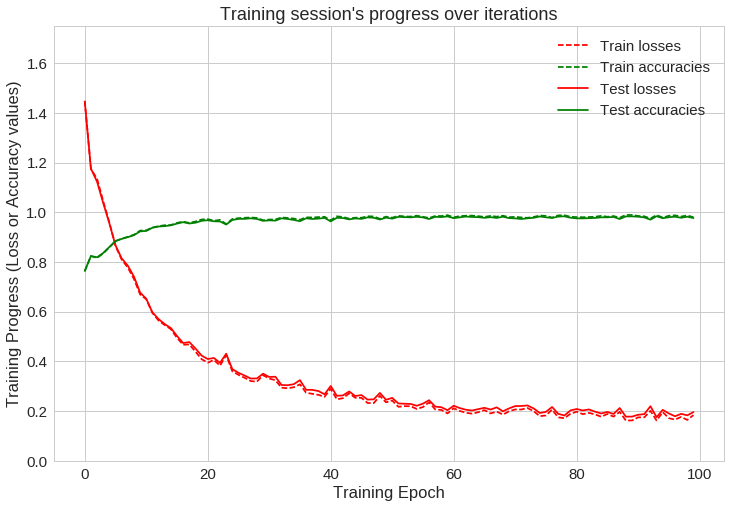

In [ ]:
width = 12
height = 8
plt.figure(figsize=(width, height))


plt.plot(np.array(history['train_loss']), "r--", label="Train losses")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracies")

plt.plot(np.array(history['test_loss']), "r-", label="Test losses")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim([0, 1.75])

plt.show()

In [ ]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32) / np.sum(confusion_matrix)*100

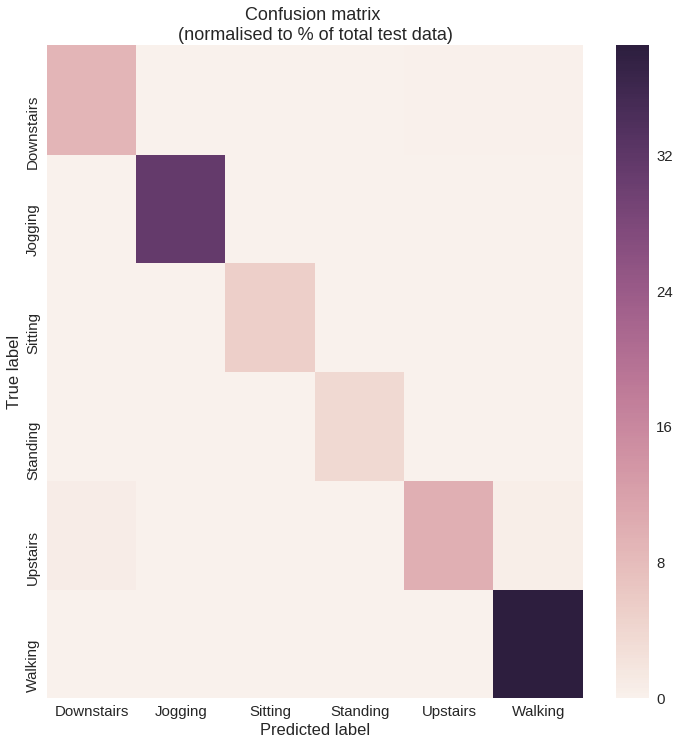

In [ ]:
width = 12
height = 12
plt.figure(figsize=(width, height))
sns.heatmap(normalised_confusion_matrix, xticklabels=LABELS, yticklabels=LABELS);
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Freeze the graph (For using in Android app)

In [ ]:
# from tensorflow.python.tools import freeze_graph

# MODEL_NAME = 'har'

# input_graph_path = 'checkpoint/' + MODEL_NAME+'.pbtxt'
# checkpoint_path = './checkpoint/' +MODEL_NAME+'.ckpt'
# restore_op_name = "save/restore_all"
# filename_tensor_name = "save/Const:0"
# output_frozen_graph_name = 'frozen_'+MODEL_NAME+'.pb'

# freeze_graph.freeze_graph(input_graph_path, input_saver="",
#                           input_binary=False, input_checkpoint=checkpoint_path, 
#                           output_node_names="y_", restore_op_name="save/restore_all",
#                           filename_tensor_name="save/Const:0", 
#                           output_graph=output_frozen_graph_name, clear_devices=True, initializer_nodes="")